# Exploration 6
# 미니 프로젝트: 영화리뷰 텍스트 감성분석하기🎬🍿

## 1. 데이터 준비

In [1]:
# 필요한 라이브러리 import
import glob
import os
import re
import numpy as np
import pandas as pd

from collections import Counter

import urllib.request
from konlpy.tag import Okt, Mecab

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

from gensim.models import KeyedVectors
import gensim
from sklearn.model_selection import train_test_split

from keras.layers import Bidirectional, LSTM, GRU, Dense, Conv1D
from keras.layers import Embedding, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 훈련 데이터, 테스트 데이터 준비
train_data = pd.read_table('~/aiffel/Exploration6/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/Exploration6/sentiment_classification/data/ratings_test.txt')

#### Train Data 확인

In [2]:
train_data.head(6)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0


#### Test Data 확인

In [3]:
test_data.head(6)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1


## 2. 데이터 로더 구성하기 

### 1) 데이터 정제 ~ 세트 분리

In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    train_data = train_data.dropna(how = 'any')  # NA값 제거
    
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    test_data = test_data.dropna(how = 'any')  # NA값 제거 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # 딕셔너리에 {텍스트:인덱스} 구조로 저장
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [5]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


### 2) 단어사전 만들기

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

### 3) encode, decode

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [8]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


## 3. 모델 구성을 위한 데이터 분석 및 가공

In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 지정 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### post padding

In [10]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='post',  #혹은 pre
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',  #혹은 pre
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


### validation set 준비

In [11]:
# 훈련 데이터 앞쪽 10000개 까지 validation set으로 사용
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지는 모두 훈련 데이터로 사용
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## 4. 모델 및 validation set 활용

### 1. LSTM

In [12]:
# LSTM 모델 구성
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [13]:
# LSTM 모델 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=5

history = model.fit(partial_X_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
266/266 [==============================] - 15s 7ms/step - loss: 0.5967 - accuracy: 0.6688 - val_loss: 0.4288 - val_accuracy: 0.8347
Epoch 2/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3637 - accuracy: 0.8472 - val_loss: 0.3419 - val_accuracy: 0.8521
Epoch 3/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3235 - accuracy: 0.8635 - val_loss: 0.3420 - val_accuracy: 0.8511
Epoch 4/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3101 - accuracy: 0.8699 - val_loss: 0.3438 - val_accuracy: 0.8493
Epoch 5/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3024 - accuracy: 0.8733 - val_loss: 0.3414 - val_accuracy: 0.8509


In [14]:
# LSTM 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3543 - accuracy: 0.8472
[0.35432037711143494, 0.847163200378418]


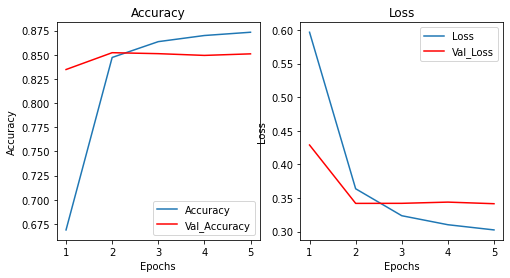

In [15]:
# Accuracy, Loss 그래프 시각화
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### 2. cnn

In [16]:
# CNN 모델 구성
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [17]:
# CNN 모델 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_X_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
266/266 [==============================] - 12s 6ms/step - loss: 0.4891 - accuracy: 0.7559 - val_loss: 0.3482 - val_accuracy: 0.8479
Epoch 2/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3230 - accuracy: 0.8632 - val_loss: 0.3372 - val_accuracy: 0.8516
Epoch 3/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2886 - accuracy: 0.8810 - val_loss: 0.3353 - val_accuracy: 0.8537
Epoch 4/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2603 - accuracy: 0.8955 - val_loss: 0.3436 - val_accuracy: 0.8525
Epoch 5/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2336 - accuracy: 0.9087 - val_loss: 0.3583 - val_accuracy: 0.8496


In [18]:
# CNN 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3649 - accuracy: 0.8495
[0.3649132549762726, 0.8495229482650757]


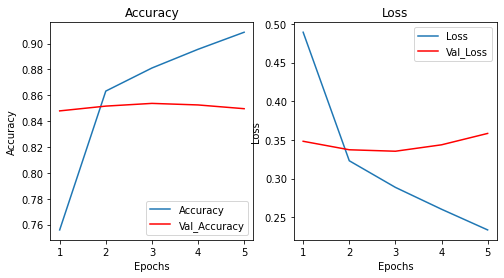

In [19]:
# Accuracy, Loss 그래프 시각화
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### 3. GlobalMaxPooling1D

In [20]:
# GlobalMaxPooling1D 모델 구성
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [21]:
# GlobalMaxPooling1D 모델 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_X_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
266/266 [==============================] - 1s 4ms/step - loss: 0.5740 - accuracy: 0.7431 - val_loss: 0.4192 - val_accuracy: 0.8247
Epoch 2/5
266/266 [==============================] - 1s 3ms/step - loss: 0.3729 - accuracy: 0.8417 - val_loss: 0.3541 - val_accuracy: 0.8444
Epoch 3/5
266/266 [==============================] - 1s 3ms/step - loss: 0.3238 - accuracy: 0.8635 - val_loss: 0.3448 - val_accuracy: 0.8464
Epoch 4/5
266/266 [==============================] - 1s 3ms/step - loss: 0.2972 - accuracy: 0.8772 - val_loss: 0.3457 - val_accuracy: 0.8468
Epoch 5/5
266/266 [==============================] - 1s 3ms/step - loss: 0.2770 - accuracy: 0.8869 - val_loss: 0.3492 - val_accuracy: 0.8465


In [22]:
# GlobalMaxPooling1D 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3625 - accuracy: 0.8444
[0.3624735176563263, 0.8443762063980103]


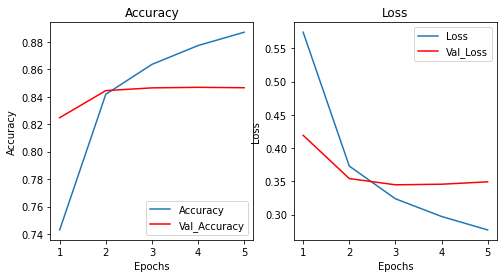

In [23]:
# Accuracy, Loss 그래프 시각화
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 5. Embedding 레이어 분석

In [24]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)        # shape: (vocab_size, embedding_dim)

(10000, 16)


In [25]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/Exploration6/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [26]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('낙', 0.8900185823440552),
 ('살렸', 0.8714560270309448),
 ('톰크루즈', 0.865547776222229),
 ('고요', 0.8635779023170471),
 ('떠오르', 0.8628420829772949),
 ('그나저나', 0.8183773756027222),
 ('충분히', 0.8172945976257324),
 ('이사', 0.8170075416564941),
 ('학생', 0.8155779838562012),
 ('루이스', 0.8132802248001099)]

## 6. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [27]:
# gensim 패키지 버전 확인
import gensim
gensim.__version__

'3.8.3'

In [28]:
# 한국어 Word2Vec 파일 불러와 ko_model에 저장하기
word2vec_path = os.getenv('HOME')+'/aiffel/Exploration6/sentiment_classification/data/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_path)
from gensim.models import KeyedVectors

# 유사한 단어와 유사도 확인
ko_model.wv.most_similar("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [29]:
ko_model['사랑'].shape

/tmp/ipykernel_121/4192617215.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  ko_model['사랑'].shape


(200,)

### ⛳️각 모델 별 성능 개선 확인
- 이제 한국어 Word2Vec을 사용해서 이전의 모델을 다시 학습시키고 평가한다.

In [30]:
vocab_size = 10000     # 단어 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수

# 사전학습된 임베딩 레이어의 차원 수 그대로 따라가는 것이 좋다
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

#embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 순서대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/tmp/ipykernel_121/3755042905.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in ko_model:
/tmp/ipykernel_121/3755042905.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = ko_model[index_to_word[i]]


### 1. LSTM

In [31]:
model_lstm = keras.Sequential()

model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), 
                                  input_length=maxlen, trainable=True))
model_lstm.add(keras.layers.LSTM(8))          
model_lstm.add(keras.layers.Dense(4, activation='relu'))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))
         
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 2,006,729
Trainable params: 2,006,729
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_lstm.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_lstm=5
history_lstm = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs_lstm,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1064/1064 [==============================] - 8s 6ms/step - loss: 0.5817 - accuracy: 0.6387 - val_loss: 0.3741 - val_accuracy: 0.8385
Epoch 2/5
1064/1064 [==============================] - 6s 6ms/step - loss: 0.3492 - accuracy: 0.8516 - val_loss: 0.3433 - val_accuracy: 0.8517
Epoch 3/5
1064/1064 [==============================] - 6s 5ms/step - loss: 0.3098 - accuracy: 0.8704 - val_loss: 0.3335 - val_accuracy: 0.8570
Epoch 4/5
1064/1064 [==============================] - 6s 5ms/step - loss: 0.2869 - accuracy: 0.8814 - val_loss: 0.3371 - val_accuracy: 0.8556
Epoch 5/5
1064/1064 [==============================] - 6s 5ms/step - loss: 0.2681 - accuracy: 0.8915 - val_loss: 0.3387 - val_accuracy: 0.8585


In [33]:
results = model_lstm.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3485 - accuracy: 0.8544
[0.34851518273353577, 0.8544459342956543]


### 2. CNN

In [34]:
# CNN
model_cnn = keras.Sequential()

model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, trainable=True))
model_cnn.add(keras.layers.Conv1D(32, 3, activation='relu'))
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(8, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid')) 

model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 39, 32)            19232     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 16)             1552      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [35]:
model_cnn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_cnn=5
history_cnn = model_cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs_cnn,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1064/1064 [==============================] - 6s 5ms/step - loss: 0.4685 - accuracy: 0.7701 - val_loss: 0.3856 - val_accuracy: 0.8231
Epoch 2/5
1064/1064 [==============================] - 5s 5ms/step - loss: 0.3362 - accuracy: 0.8546 - val_loss: 0.3361 - val_accuracy: 0.8515
Epoch 3/5
1064/1064 [==============================] - 5s 5ms/step - loss: 0.2953 - accuracy: 0.8753 - val_loss: 0.3352 - val_accuracy: 0.8519
Epoch 4/5
1064/1064 [==============================] - 5s 5ms/step - loss: 0.2686 - accuracy: 0.8883 - val_loss: 0.3373 - val_accuracy: 0.8564
Epoch 5/5
1064/1064 [==============================] - 5s 5ms/step - loss: 0.2440 - accuracy: 0.9009 - val_loss: 0.3428 - val_accuracy: 0.8534


In [36]:
results2 = model_cnn.evaluate(X_test, y_test, verbose=2)

print(results2)

1537/1537 - 3s - loss: 0.3553 - accuracy: 0.8506
[0.35526230931282043, 0.8505604267120361]


### 3. GlobalMaxPooling1D

In [37]:
model_gmp = keras.Sequential()

model_gmp.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, trainable=True))
model_gmp.add(keras.layers.GlobalMaxPooling1D())
model_gmp.add(keras.layers.Dense(8, activation='relu'))
model_gmp.add(keras.layers.Dense(1, activation='sigmoid')) 

model_gmp.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_gmp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_gmp=5
history_gmp = model_gmp.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs_gmp,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
2128/2128 [==============================] - 8s 3ms/step - loss: 0.5447 - accuracy: 0.7163 - val_loss: 0.4642 - val_accuracy: 0.7804
Epoch 2/5
2128/2128 [==============================] - 7s 3ms/step - loss: 0.4262 - accuracy: 0.8026 - val_loss: 0.4149 - val_accuracy: 0.8088
Epoch 3/5
2128/2128 [==============================] - 7s 3ms/step - loss: 0.3778 - accuracy: 0.8313 - val_loss: 0.4002 - val_accuracy: 0.8174
Epoch 4/5
2128/2128 [==============================] - 7s 3ms/step - loss: 0.3445 - accuracy: 0.8501 - val_loss: 0.3919 - val_accuracy: 0.8225
Epoch 5/5
2128/2128 [==============================] - 7s 3ms/step - loss: 0.3177 - accuracy: 0.8640 - val_loss: 0.3818 - val_accuracy: 0.8316


In [39]:
results3 = model_gmp.evaluate(X_test, y_test, verbose=2)

print(results3)

1537/1537 - 2s - loss: 0.3904 - accuracy: 0.8294
[0.39035338163375854, 0.8294240832328796]


# 🔥프로젝트 결과🔥
1. LSTM -> 한국어 Word2Vec 임베딩 전 84.72% / 임베딩 후 85.44%

2. CNN -> 한국어 Word2Vec 임베딩 전 84.95% / 임베딩 후 85.06%

3. GlobalMaxPooling1D -> 한국어 Word2Vec 임베딩 전 84.44% / 임베딩 후 82.94%

# 회고
1. 어려웠던 점: 정확도 85%가 생각보다 잘 안나와서 85% 맞추는게 힘들었다.
2. 알게 된 점: gensim을 사용해서 유사어를 출력했을 때 전혀 관련이 없는 단어들이 많이 출력되었다. gensim은 한국어와는 잘 맞지 않는 라이브러리가 아닐까 하는 생각이 든다.

# 이번 노드하면서...
Exploration을 진행하면서 역시 자연어...

하면 할수록 자연어는 지쳐가는것 같다.

그래도 마지막에 결과를 딱 보면 "휴 오늘도 자연어 물리쳤다.."약간 이런?

다음에 자연어를 할때는 미리 자연어를 조금 더 공부 해야겠다.

(그러면 좀 더 쉽게? 잘? 할 수 있을 것 같은 느낌이..)